In [126]:
import pandas as pd
import numpy as np
import time 
import pixiedust
import sys

from pomegranate import State, DiscreteDistribution, HiddenMarkovModel
from sklearn.model_selection import train_test_split
from utils import load_gfp_data, count_substring_mismatch, get_all_amino_acids, get_wild_type_amino_acid_sequence
from hmm import GenerativeHMM, hmm_amino_acid_args
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
print("Loading data...")
start_time = time.time()
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_")
print("Finished loading data in {0:.2f} seconds".format(time.time() - start_time))

Loading data...
Finished loading data in 0.06 seconds


In [128]:
wild_type_amino_acid = get_wild_type_amino_acid_sequence()
assert(X_train[0] == wild_type_amino_acid)
assert(count_substring_mismatch(wild_type_amino_acid, X_train[1000]) == 8)

In [129]:
def get_data(X_train, length, n = 100, random=True): 
    if not random: 
        data = X_train[0:length]
    else: 
        indexes = np.random.choice(len(X_train), n)
        data = X_train[indexes]
    return np.array([list(x)[0:length] for x in data])

def sample_and_score(hmm, wild_type, n = 100, length = 100, logger = None):
    """
    use the hmm model to sample n sequences of size = length. 
    then use the wild_type to count how far off the average sample is from the wild_type
    """
    assert(len(wild_type) == length)
    samples = hmm.sample(n, length)        
    average_diff = np.average([count_substring_mismatch(seq, wild_type) for seq in samples])
    print("Average difference: {0:.2f}, or {1:.2f} mismatches per letter".format(average_diff, 
                                                                 average_diff / length), file = logger)
    print("Example sequence {0}".format(samples[np.random.randint(0, n)]), file = logger)
    return average_diff

small_length, medium_length, large_length = 15, len(wild_type_amino_acid) // 4, len(wild_type_amino_acid)
small_X = get_data(X_train, small_length, 100)
medium_X = get_data(X_train, medium_length, 100)
large_X = get_data(X_train, large_length, 100)

In [130]:
diffs = [count_substring_mismatch(i, wild_type_amino_acid[0:small_length]) for i in small_X]
print("Small diffs:", diffs)
diffs = [count_substring_mismatch(i, wild_type_amino_acid[0:medium_length]) for i in medium_X]
print("Medium diffs:", diffs)
diffs = [count_substring_mismatch(i, wild_type_amino_acid[0:large_length]) for i in large_X]
print("Large diffs:", diffs)

Small diffs: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0]
Medium diffs: [2, 0, 0, 0, 3, 2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 2, 1, 3, 0, 0, 0, 0, 1, 0, 3, 1, 0, 2, 0, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 3, 2, 0, 1, 0, 1, 1, 4]
Large diffs: [5, 2, 3, 3, 2, 1, 2, 4, 2, 3, 1, 3, 4, 3, 6, 4, 3, 1, 6, 2, 5, 2, 0, 1, 3, 2, 7, 2, 5, 6, 3, 1, 2, 3, 0, 7, 1, 3, 2, 5, 3, 2, 8, 2, 5, 2, 5, 2, 3, 5, 3, 2, 3, 8, 4, 8, 7, 3, 2, 4, 4, 3, 2, 7, 4, 5, 8, 2, 4, 1, 5, 3, 5, 2, 2, 5, 5, 4, 2, 3, 3, 2, 1, 0, 8, 3, 7, 3, 2, 8, 3, 1, 6, 6, 6, 2, 6, 3, 10, 3]


In [131]:
def get_data(X_train, length, n = 100, random = True): 
    """
    gets n random sequences of size length from the dataset X_train
    """
    if not random: 
        data = X_train[0:length]
    else: 
        indexes = np.random.choice(len(X_train), n)
        data = X_train[indexes]
    return np.array([list(x[0:length]) for x in data])

def sample_and_score(hmm, base_str, n = 100, length = 100, logger = None):
    """
    use the hmm model to sample n sequences of size = length. 
    then use the wild_type to count how far off the average sample is from the wild_type
    prints all results in the logger file
    """
    assert(len(base_str) == length)
    samples = hmm.sample(n, length)        
    average_diff = np.mean([count_substring_mismatch(seq, base_str) for seq in samples])
    print("Average difference: {0:.2f}, or {1:.2f} mismatches per letter".format(average_diff, 
                                                                 average_diff / length), file = logger)
    print("Example sequence {0}".format(samples[np.random.randint(0, n)]), file = logger)
    return average_diff

def train_and_save_hmm(X, args):
    start_time = time.time()
    hmm = GenerativeHMM(args)
    logger = None
    hmm.fit(X)
    print("Finished training in {:.2f} seconds".format(time.time() - start_time), file = logger)
    print("HMM Parameters:", file = logger)
    print(hmm.get_args(), file = logger)
    sample_and_score(hmm, wild_type_amino_acid[0:args["length"]], 100, args["length"], logger = logger)
    wild_type_prob = np.e ** hmm.predict([list(wild_type_amino_acid[0:args["length"]])])
    mutation_prob = np.e ** hmm.predict([list(wild_type_amino_acid[0:args["length"] - 3] + "ACG")])
    print("Wild type prob: {0}. Mutation prob: {1}".format(wild_type_prob, mutation_prob), file = logger)
    model_path = "./models/{0}.json".format(hmm.name)
    hmm.save_model(model_path)
    cached_hmm = GenerativeHMM(args)
    cached_hmm.load_model(model_path)
    try: 
        for i in get_all_amino_acids():
            for j in get_all_amino_acids(): 
                np.testing.assert_almost_equal(hmm.predict([list(i + j)]), cached_hmm.predict([list(i + j)]))
        print("Successfully finished training and saving {0} model!".format(hmm.name), file = logger)
        if logger: logger.close()
    except:
        for i in get_all_amino_acids():
            for j in get_all_amino_acids(): 
                print(hmm.predict([list(i + j)]), cached_hmm.predict([list(i + j)]), file = logger)
        print("Error in loading {0} hmm".format(hmm.name), file = logger)
        if logger: logger.close()

def get_args(parser_args):
    args = hmm_amino_acid_args()
    args["n_jobs"] = parser_args.n_jobs
    args["hidden_size"] = parser_args.hidden_size
    args["max_iterations"] = parser_args.max_iterations
    args["name"] = parser_args.name
    args["length"] = parser_args.length
    return args

def get_base_args():
    base_args = hmm_amino_acid_args()
    base_args["name"] = "hmm_base"
    base_args["max_iterations"] = 100
    base_args["hidden_size"] = 20
    base_args["n_jobs"] = 10
    base_args["epochs"] = 100
    base_args["pseudo_count"] = 1
    base_args["length"] = 59
    base_args["vocabulary"] = get_all_amino_acids()
    return base_args

In [132]:
train_and_save_hmm(small_X, get_base_args())

AttributeError: 'GenerativeHMM' object has no attribute 'pseudocount'

In [134]:
args = get_base_args()
hmm = GenerativeHMM(args)
print(hmm.num_characters, hmm.hidden_size)
x_train = get_data(X_train, medium_length, 1000)
x_valid = get_data(X_train, medium_length, 1000)
train_loss_history = []
for epoch in range(1, 101):
    total_train_loss = 0
    improvement, hist = hmm.model.fit(x_train, max_iterations=1, pseudocount=1, n_jobs= hmm.n_jobs, return_history=True)
    print("Epoch {0}. Improvement: {1}, last log probability: {2}. current neg log probability {3}".format(
                        epoch, hist.total_improvement[0], hist.initial_log_probability, hist.log_probabilities))
    print(-sum([hmm.model.log_probability(x_train[i]) for i in range(len(x_train))]) / len(x_train))
    print(-sum(hmm.model.log_probability(x_test[i]) for i in range(len(x_test))) / len(x_test))

x_test = get_data(X_train, medium_length, 100)

21 20
Epoch 1. Improvement: 27554.374772003037, last log probability: -180638.91089909413. current neg log probability [-153084.5361270911]
152.51405102369088
152.43382920909707
Epoch 2. Improvement: 834.4504665236745, last log probability: -152514.05102369076. current neg log probability [-151679.60055716708]
150.21006389214267
150.12102479889478
Epoch 3. Improvement: 2475.421466125874, last log probability: -150210.0638921414. current neg log probability [-147734.64242601552]
143.6503457398613
143.5266000626552
Epoch 4. Improvement: 6976.518032398832, last log probability: -143650.34573986137. current neg log probability [-136673.82770746254]
126.31968784142974
126.0810135275985
Epoch 5. Improvement: 13496.936220349948, last log probability: -126319.68784143034. current neg log probability [-112822.75162108039]
98.0275632508071
97.62493345041918
Epoch 6. Improvement: 10686.417211129243, last log probability: -98027.56325080719. current neg log probability [-87341.14603967794]
80.6061

KeyboardInterrupt: 

In [58]:
from utils import one_hot_encode, one_hot_decode
x_encoded = one_hot_encode(x_test, get_all_amino_acids())
for i in range(len(x_test)):
    z = hmm.model.log_probability(x_test[i])
    print(np.e ** z)

0.0
3.0381551702700104e-10
2.7012103881314226e-22
3.0381551702700104e-10
3.2320799683723786e-12
3.0381551702700104e-10
0.0
6.200316694498537e-12
0.0
0.0
3.0381551702700104e-10
7.995145184921112e-12
4.797087110952642e-12
3.0381551702700104e-10
6.52224667018753e-18
5.240333403890258e-20
3.0688436063333424e-12
3.181314314418894e-12
6.200316694498537e-12
3.0688436063333315e-12
3.0381551702700104e-10
3.0688436063333424e-12
3.0381551702700104e-10
3.0381551702700104e-10
0.0
0.0
3.0381551702700104e-10
0.0
3.0381551702700104e-10
3.0381551702700104e-10
6.242784596445215e-12
7.95328578604713e-12
3.0381551702700104e-10
3.0381551702700104e-10
3.0381551702700104e-10
9.857028310176642e-14
7.995145184921112e-12
1.2557819662179663e-13
3.824898350852471e-16
3.0381551702700104e-10
3.0381551702700104e-10
3.0381551702700104e-10
3.0381551702700104e-10
0.0
3.0381551702700104e-10
0.0
3.0381551702700104e-10
3.2320799683723786e-12
3.2966321329403576e-10
0.0
0.0
3.0688436063333315e-12
3.0381551702700104e-10
0.0


In [21]:
"""
10, 100 sequences, 100 iterations, 100 sequences. 
10, 200, 1e8, 100 sequences, 
10, 200, 1000, 100 sequences. 
10, 500, 1000, 100 sequences. 
10, 200, 1000, 10000 seqeunces. 


## Fit 3 types.
## Fit small data -> large data. 
## Fit with different hidden sizes 10, 50, 200. 
## fit until it 1e8, 1e2 iterations
## all with more cores 5
## record times of all these. 
"""

'\n10, 100 sequences, 100 iterations, 100 sequences. \n10, 200, 1e8, 100 sequences, \n10, 200, 1000, 100 sequences. \n10, 500, 1000, 100 sequences. \n10, 200, 1000, 10000 seqeunces. \n\n\n## Fit 3 types.\n## Fit small data -> large data. \n## Fit with different hidden sizes 10, 50, 200. \n## fit until it 1e8, 1e2 iterations\n## all with more cores 5\n## record times of all these. \n'

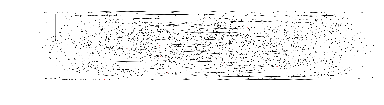

In [135]:
fig = hmm.model.plot()
hmm.model.plot()